# Objetivos deste trabalho:
- Se familiarizar com o ambiente Notebook e com Python
- Implementar um perceptron simples, treiná-lo no conjunto de TREINO do CIFAR-10 e avaliá-lo no conjunto de TESTE (alvo: distinguir fotos de animais de meios de transporte)
- Utilizar a função sigmóide e verificar seu efeito no treinamento e na avaliação
- Modificar a metodologia para classificar cada classe individualmente (i.e. treinar 10 perceptrons, um para cada classe). Considerar: dado um exemplo, que passará por cada perceptron, como decidir qual é a classe dele?

In [1]:
%matplotlib inline

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Carregar os datasets

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
print(len(dataset_train), len(dataset_test))

50000 10000


In [5]:
# Converter para tons de cinza

# Treino
grayscale_dataset_train = []
for img,label in dataset_train:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_train.append((gray_npimg,category))
    
# Teste
grayscale_dataset_test = []
for img,label in dataset_test:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_test.append((gray_npimg,category))    

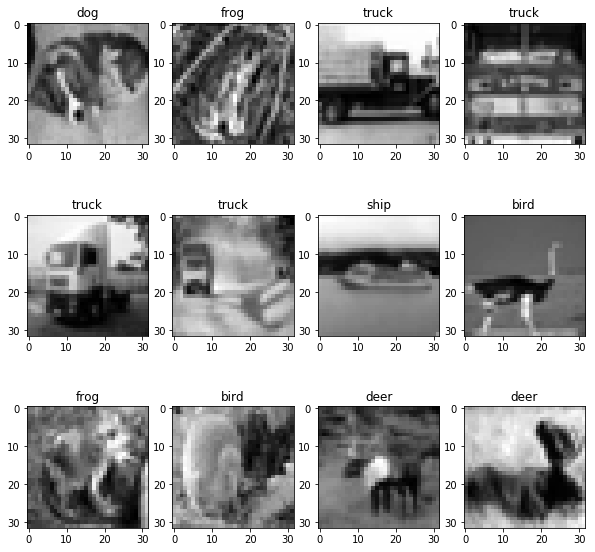

In [6]:
# Mostrar imagens

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    image_index = random.randint(0, len(dataset_train))
    label = grayscale_dataset_train[image_index][1]
    npimg = grayscale_dataset_train[image_index][0]

    fig.add_subplot(rows, columns, i)
    
    plt.imshow(npimg, cmap='gray')
    plt.title(label)
    
plt.show()

In [7]:
# Converter para vetores 1D

# Para pensar: por que a divisão por 255 no código abaixo?
# Serve para evitar weights de magnitudes muito elevadas, visto que é a relação entre eles que prevalece
# Como os valores dos pixels vão de 0 até 255, dividir eles pelo máximo resulta num valor entre 0 e 1.

linear_dataset_train = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_train:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_train.append((linear_img,label))
    
linear_dataset_test = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_test.append((linear_img,label))    

In [8]:
size = len(linear_dataset_train[0][0])
print(size)

1024


# Definindo o perceptron

In [9]:
class Perceptron(object):
    
    def __init__(self, neta=0.001):
        self.neta = neta
        self.weights = (np.random.rand(1,size) - 0.5)[0]
        bias = (np.random.rand(1) - 0.5) 
        self.weights = np.append(self.weights, bias) 
        self.accuracies = []
        self.losses = []
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def predict(self, inputs):
        o = np.dot(inputs, self.weights)
        y = self.sigmoid(o)
        return y
    

    def evaluate(self, dataset):
        hits = 0
        for image,label in dataset:
            image = np.append(image, 1)
            # Defina a métrica de avaliação do perceptron aqui (e.g. acurácia)
            y = self.predict(image)

            if(y >= 0.5 and label == 1):
                hits += 1

            elif(y < 0.5 and label == 0):
                hits += 1

        accuracy = hits / len(dataset)
        return accuracy
    
    
    def train(self, dataset, epochs=100, verbose="not_verbose", ballance_multiplier=1):
        np.random.shuffle(dataset)

        for epoch in range(epochs):
            hits = 0
            loss = 0
            for image, label in dataset:
                image = np.append(image, 1)
                
                y = self.predict(image)
                reward = 1
                
                    
                if label == 1:
                    reward = ballance_multiplier
                    
                if(y >= 0.5 and label == 1):
                    hits += 1
                    

                elif(y < 0.5 and label == 0):
                    hits += 1

                delta_weights = self.neta * (label - y) * image * y * (1 - y) * reward
                self.weights += delta_weights
                loss += (label - y)**2

            accuracy = hits / len(linear_dataset_train)
            self.accuracies = np.append(self.accuracies, accuracy)
            self.losses = np.append(self.losses, loss)

            if(verbose == "verbose"):
                print("%5.0f %12f %15f" %(epoch+1, accuracy, loss))
                #print(epoch,"\t", accuracy, "\t", loss)
            
    
    def plotResults(self):
        plt.plot(self.accuracies)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy")
        plt.show()

        plt.plot(self.losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()

# Treinando o perceptron

In [10]:
p0 = Perceptron()
p0.train(linear_dataset_train, 100, "verbose")

    1     0.670840    11474.937975
    2     0.693760    10842.976315
    3     0.701000    10621.196863
    4     0.704220    10470.318195
    5     0.707280    10352.749833
    6     0.709040    10255.974294
    7     0.710820    10173.903304
    8     0.712460    10102.969363
    9     0.714180    10040.882941
   10     0.715060     9986.075025
   11     0.715620     9937.402281
   12     0.716220     9893.984019
   13     0.717580     9855.111153
   14     0.718520     9820.194571
   15     0.719280     9788.734842
   16     0.719820     9760.303419
   17     0.720660     9734.530066
   18     0.721100     9711.093768
   19     0.721600     9689.715679
   20     0.722400     9670.153355
   21     0.722800     9652.195889
   22     0.723040     9635.659727
   23     0.723300     9620.385034
   24     0.723240     9606.232540
   25     0.723800     9593.080784
   26     0.724460     9580.823727
   27     0.725040     9569.368681
   28     0.725400     9558.634509
   29     0.725580  

In [11]:
# Avalie o modelo treinado aqui
# Como a acurácia no conjunto de teste se compara com a acurácia obtida no conjunto de treino?

# A acurácia no conjunto de treino é maior devido ao overfitting do conjunto de treinamento.
# Analogamente, a acurácia do conjunto de teste é menor justamente pelo fato de que as imagens do 
# conjunto de teste nunca foram apresentadas ao modelo.

accuracy_train = p0.evaluate(linear_dataset_train)
accuracy_test = p0.evaluate(linear_dataset_test)

print("Train Accuracy: ", accuracy_train, "\tTest Accuracy: ", accuracy_test)


Train Accuracy:  0.73498 	Test Accuracy:  0.7252


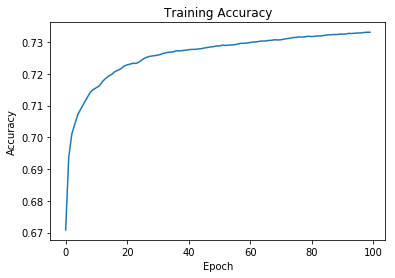

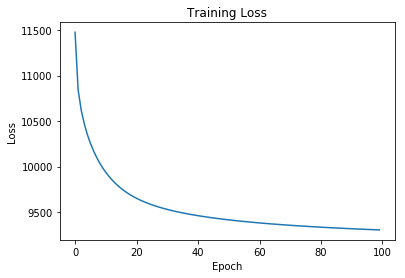

In [12]:
# Caso queiram plotar alguma coisa

p0.plotResults()


# Classificando classes individuais

Implemente aqui a modificação do processo de avaliação e treinamento para poder classificar cada classe individualmente.

- Ideia geral: treinar um perceptron por classe (exemplo positivo = exemplos da classe; exemplos negativos = exemplo de todas outras classes)
- Dado um exemplo qualquer, como decidir qual perceptron está dando a classe correta?

In [13]:
def classes_get(x):
    return {
        0: "plane",
        1: "car",
        2: "bird",
        3: "cat",
        4: "deer",
        5: "dog",
        6: "frog",
        7: "horse",
        8: "ship",
        9: "truck",
    }[x]

In [14]:
# converter para vetores 1D

linear_dataset_array_train = [[] for i in range(10)]
linear_dataset_array_test = [[] for i in range(10)]

for index in range(10):
    
    target_labels = classes_get(index)
    for img,category in grayscale_dataset_train:
        linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
        #linear_img = img
        if category in target_labels:
            label = 1
        else:
            label = 0
        linear_dataset_array_train[index].append((linear_img,label))

    
    
    for img,category in grayscale_dataset_test:
        linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
        #linear_img = img
        if category in target_labels:
            label = 1
        else:
            label = 0
        linear_dataset_array_test[index].append((linear_img,label))
    

In [15]:
print(len(linear_dataset_array_train))
print(len(linear_dataset_array_train[0]))

print(len(linear_dataset_array_test))
print(len(linear_dataset_array_test[0]))

10
50000
10
10000


############################################
Training Perceptron 0
    1     0.466380    17316.306866
    2     0.519140    15138.385749
    3     0.538880    14357.565171
    4     0.553320    13854.127486
    5     0.565540    13495.625748
    6     0.574080    13230.655354
    7     0.581200    13028.474482
    8     0.587460    12869.588294
    9     0.592880    12741.435457
   10     0.596100    12635.783821
   11     0.599460    12547.111390
   12     0.602400    12471.606956
   13     0.605260    12406.557504
   14     0.607700    12349.971908
   15     0.609520    12300.347224
   16     0.611060    12256.520888
   17     0.612360    12217.574969
   18     0.613020    12182.772400
   19     0.614300    12151.513192
   20     0.615760    12123.303475
   21     0.616960    12097.732973
   22     0.617680    12074.458211
   23     0.619240    12053.189732
   24     0.619860    12033.682177
   25     0.620500    12015.726495
   26     0.621100    11999.143733
   27     0.622160    1

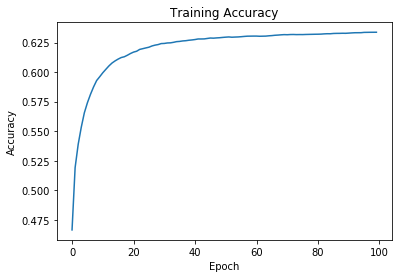

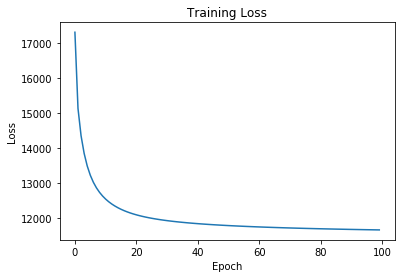




############################################
Training Perceptron 1
    1     0.648960    11999.544028
    2     0.693120    10752.346228
    3     0.700540    10508.280773
    4     0.704220    10364.856841
    5     0.706220    10262.108745
    6     0.708260    10184.626685
    7     0.709740    10124.863257
    8     0.710700    10077.924112
    9     0.711740    10040.394484
   10     0.711940    10009.842859
   11     0.712560     9984.516186
   12     0.712020     9963.136888
   13     0.712260     9944.765604
   14     0.712180     9928.706956
   15     0.712760     9914.443567
   16     0.712840     9901.588939
   17     0.712880     9889.853274
   18     0.713180     9879.018415
   19     0.713580     9868.919367
   20     0.713880     9859.430631
   21     0.713900     9850.456105
   22     0.714420     9841.921615
   23     0.714820     9833.769394
   24     0.715120     9825.954006
   25     0.715440     9818.439323
   26     0.715700     9811.196285
   27     0.716000  

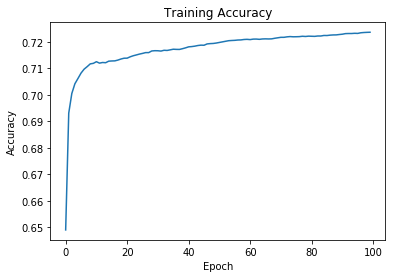

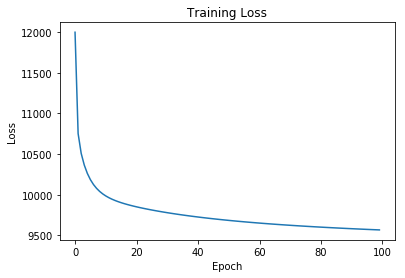




############################################
Training Perceptron 2
    1     0.494200    16059.880729
    2     0.531460    14513.500585
    3     0.534760    14259.981337
    4     0.536220    14097.244791
    5     0.538040    13979.962831
    6     0.537960    13890.191632
    7     0.538860    13818.416953
    8     0.539820    13758.912207
    9     0.541420    13708.052399
   10     0.542400    13663.502168
   11     0.542920    13623.736938
   12     0.543440    13587.742551
   13     0.544520    13554.826625
   14     0.545940    13524.501089
   15     0.547060    13496.409325
   16     0.547340    13470.280862
   17     0.547700    13445.902988
   18     0.548420    13423.102763
   19     0.549280    13401.735478
   20     0.549860    13381.677122
   21     0.549960    13362.819394
   22     0.550480    13345.066320
   23     0.550560    13328.331924
   24     0.551220    13312.538563
   25     0.551920    13297.615716
   26     0.552120    13283.499067
   27     0.552100  

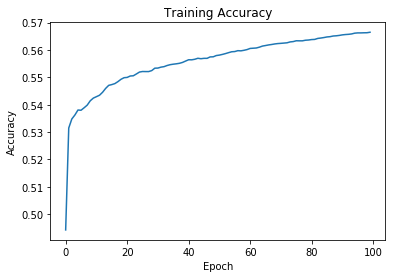

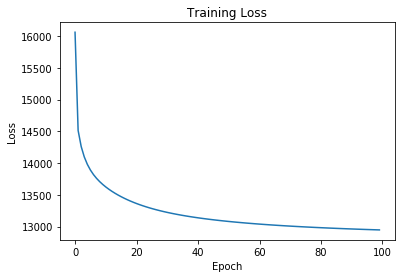




############################################
Training Perceptron 3
    1     0.520040    15059.207091
    2     0.549520    13852.892230
    3     0.554020    13565.258959
    4     0.556260    13404.902509
    5     0.556360    13297.893427
    6     0.555900    13221.140469
    7     0.555820    13163.081747
    8     0.556980    13117.178850
    9     0.557440    13079.519646
   10     0.558080    13047.655065
   11     0.558120    13019.999538
   12     0.558040    12995.500886
   13     0.558820    12973.446531
   14     0.559720    12953.344375
   15     0.560780    12934.847407
   16     0.561380    12917.705140
   17     0.561840    12901.731978
   18     0.562400    12886.786437
   19     0.562640    12872.757439
   20     0.563200    12859.555206
   21     0.563760    12847.105184
   22     0.564220    12835.343968
   23     0.564900    12824.216541
   24     0.565420    12813.674382
   25     0.565720    12803.674164
   26     0.566040    12794.176823
   27     0.566560  

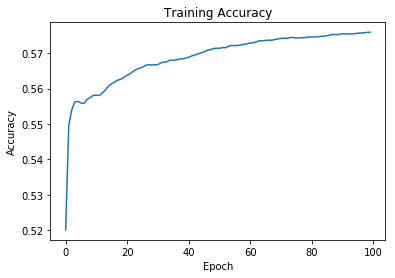

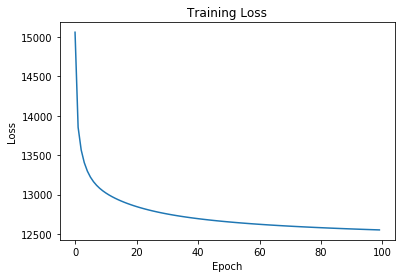




############################################
Training Perceptron 4
    1     0.523120    15224.765362
    2     0.547560    14221.538285
    3     0.551660    13923.414623
    4     0.553320    13725.867256
    5     0.554720    13590.311370
    6     0.556780    13493.313942
    7     0.557080    13420.730543
    8     0.556620    13364.102984
    9     0.556920    13318.252128
   10     0.557360    13279.916548
   11     0.558700    13246.989051
   12     0.559500    13218.076176
   13     0.560180    13192.236159
   14     0.560740    13168.818936
   15     0.561220    13147.366247
   16     0.561820    13127.548038
   17     0.562680    13109.121243
   18     0.563120    13091.902660
   19     0.563400    13075.750852
   20     0.564120    13060.553917
   21     0.564260    13046.221148
   22     0.564460    13032.677282
   23     0.564900    13019.858508
   24     0.564940    13007.709673
   25     0.565440    12996.182305
   26     0.565500    12985.233210
   27     0.565580  

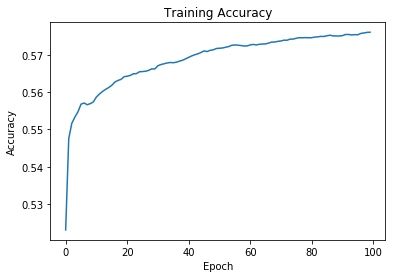

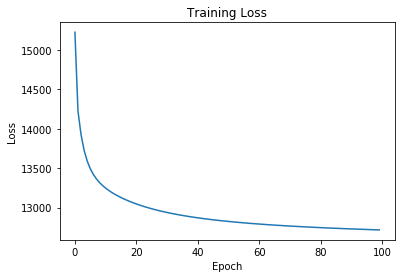




############################################
Training Perceptron 5
    1     0.580180    13749.016193
    2     0.598620    12848.795770
    3     0.602060    12581.184444
    4     0.604160    12415.774397
    5     0.604600    12303.888590
    6     0.606860    12222.918690
    7     0.607180    12161.371362
    8     0.607740    12113.078494
    9     0.608200    12074.365177
   10     0.608560    12042.804871
   11     0.609560    12016.682316
   12     0.610420    11994.740472
   13     0.610700    11976.041395
   14     0.610720    11959.878186
   15     0.611020    11945.714316
   16     0.611320    11933.140148
   17     0.611000    11921.841224
   18     0.610800    11911.574922
   19     0.610780    11902.153142
   20     0.611080    11893.429375
   21     0.611440    11885.288991
   22     0.611240    11877.641883
   23     0.611100    11870.416876
   24     0.611460    11863.557453
   25     0.611840    11857.018469
   26     0.611520    11850.763629
   27     0.611840  

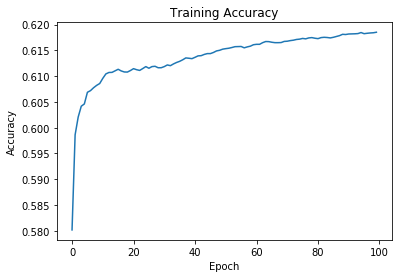

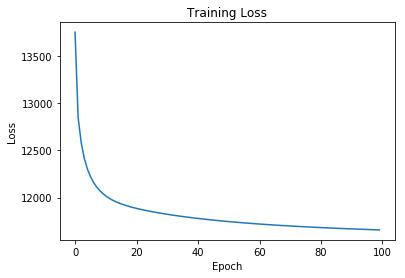




############################################
Training Perceptron 6
    1     0.537920    15327.737207
    2     0.566760    14088.183833
    3     0.572700    13694.434676
    4     0.576320    13463.131590
    5     0.579180    13310.356301
    6     0.580120    13203.718343
    7     0.581520    13126.669445
    8     0.582600    13069.161205
    9     0.584060    13024.720834
   10     0.584740    12989.119287
   11     0.585380    12959.586936
   12     0.586080    12934.305802
   13     0.586120    12912.075934
   14     0.586780    12892.098094
   15     0.587100    12873.833548
   16     0.587500    12856.913961
   17     0.587440    12841.083402
   18     0.587680    12826.160804
   19     0.588120    12812.015465
   20     0.588640    12798.550923
   21     0.589280    12785.694230
   22     0.589500    12773.388768
   23     0.589940    12761.589390
   24     0.589920    12750.259105
   25     0.590040    12739.366813
   26     0.590540    12728.885739
   27     0.591160  

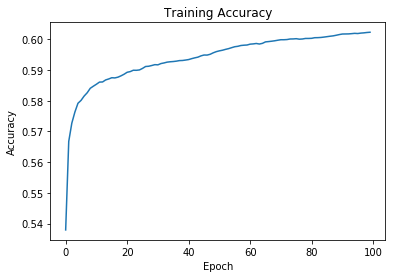

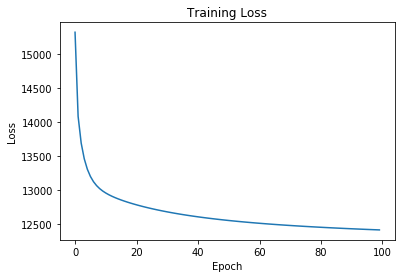




############################################
Training Perceptron 7
    1     0.576500    14013.652561
    2     0.589120    13125.859769
    3     0.592020    12872.315389
    4     0.594000    12715.464657
    5     0.595960    12603.800165
    6     0.596580    12519.191081
    7     0.597980    12452.128412
    8     0.598380    12397.285410
    9     0.598700    12351.393461
   10     0.599280    12312.275574
   11     0.600000    12278.402987
   12     0.600100    12248.669447
   13     0.600580    12222.259783
   14     0.601260    12198.564854
   15     0.601600    12177.123163
   16     0.601920    12157.579781
   17     0.602180    12139.657233
   18     0.602660    12123.134851
   19     0.603280    12107.834144
   20     0.603260    12093.608391
   21     0.603700    12080.335215
   22     0.604360    12067.911233
   23     0.604180    12056.248146
   24     0.604460    12045.269845
   25     0.604780    12034.910236
   26     0.605160    12025.111558
   27     0.605500  

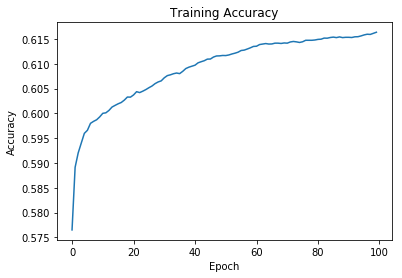

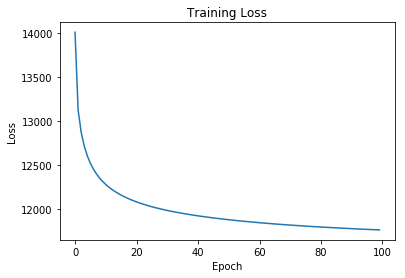




############################################
Training Perceptron 8
    1     0.585140    14609.500732
    2     0.614280    13316.633562
    3     0.622440    12768.345137
    4     0.631780    12374.112773
    5     0.639700    12076.305507
    6     0.644860    11845.588375
    7     0.650360    11663.178408
    8     0.654680    11516.205765
    9     0.658280    11395.845209
   10     0.661880    11295.946295
   11     0.665420    11212.094425
   12     0.667660    11141.026682
   13     0.669500    11080.273405
   14     0.670960    11027.931056
   15     0.672780    10982.511527
   16     0.674160    10942.837891
   17     0.675360    10907.969977
   18     0.676680    10877.149986
   19     0.677640    10849.762103
   20     0.678460    10825.302085
   21     0.678960    10803.354126
   22     0.679400    10783.573074
   23     0.679980    10765.670659
   24     0.681060    10749.404710
   25     0.681480    10734.570680
   26     0.681760    10720.994909
   27     0.682240  

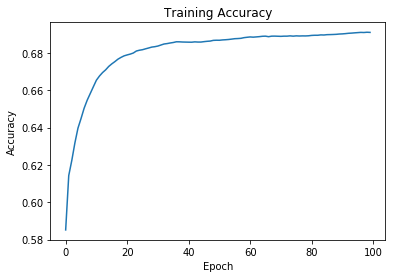

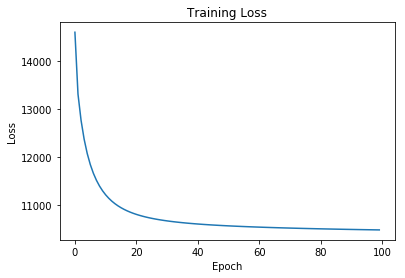




############################################
Training Perceptron 9
    1     0.670320    11774.881374
    2     0.711380    10440.888044
    3     0.718280    10186.703920
    4     0.722540    10019.441353
    5     0.724280     9890.901818
    6     0.726860     9787.852861
    7     0.728740     9703.326826
    8     0.730320     9632.561199
    9     0.731900     9572.302372
   10     0.733120     9520.281996
   11     0.734460     9474.863018
   12     0.735400     9434.823820
   13     0.736260     9399.229144
   14     0.737340     9367.349645
   15     0.738360     9338.608441
   16     0.739080     9312.543673
   17     0.739360     9288.781408
   18     0.740020     9267.015664
   19     0.739800     9246.993543
   20     0.740460     9228.504064
   21     0.740940     9211.369693
   22     0.741040     9195.439863
   23     0.741500     9180.585952
   24     0.742060     9166.697356
   25     0.742360     9153.678381
   26     0.742500     9141.445765
   27     0.742800  

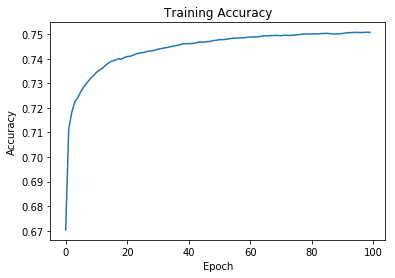

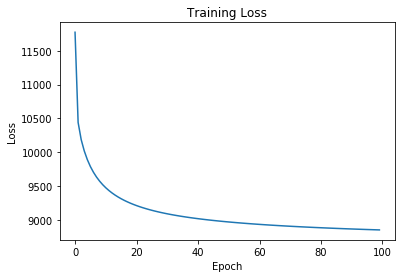

In [16]:

perceptrons = [Perceptron(0.001) for i in range(10)]
index = 0

for p in perceptrons:
    print("############################################")
    print("Training Perceptron", index)

    p.train(linear_dataset_array_train[index], 100, "verbose", 10)

    accuracy_train = p.evaluate(linear_dataset_array_train[index])
    accuracy_test = p.evaluate(linear_dataset_array_test[index])

    print("\nTrain Accuracy: ", accuracy_train, "\tTest Accuracy: ", accuracy_test, "\n")

    p.plotResults()

    print("\n\n")
    index += 1


In [17]:
linear_dataset_test_labels = []

for img,category in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    label = classes.index(category)
    linear_dataset_test_labels.append((linear_img,label))


In [18]:
hits = 0
most_active_perceptron = 0

for image,label in linear_dataset_test_labels:
    #print("label:",label)
    image = np.append(image, 1)
    index = 0
    max_output = 0
    #print("=========predictions===========")
    for p in perceptrons:
        result = p.predict(image)
        #print("Result:", result)
        #print("max:", max_output)
        if result > max_output:
            #print("bigger!")
            max_output = result
            most_active_perceptron = index
            #print("most_active:", most_active_perceptron)
        index += 1
    
    #print(most_active_perceptron)
    if label == most_active_perceptron:
        hits += 1
        #print("hit!")
    
    #break
    
accuracy = hits / len(linear_dataset_test_labels)

print(accuracy)

0.2525
